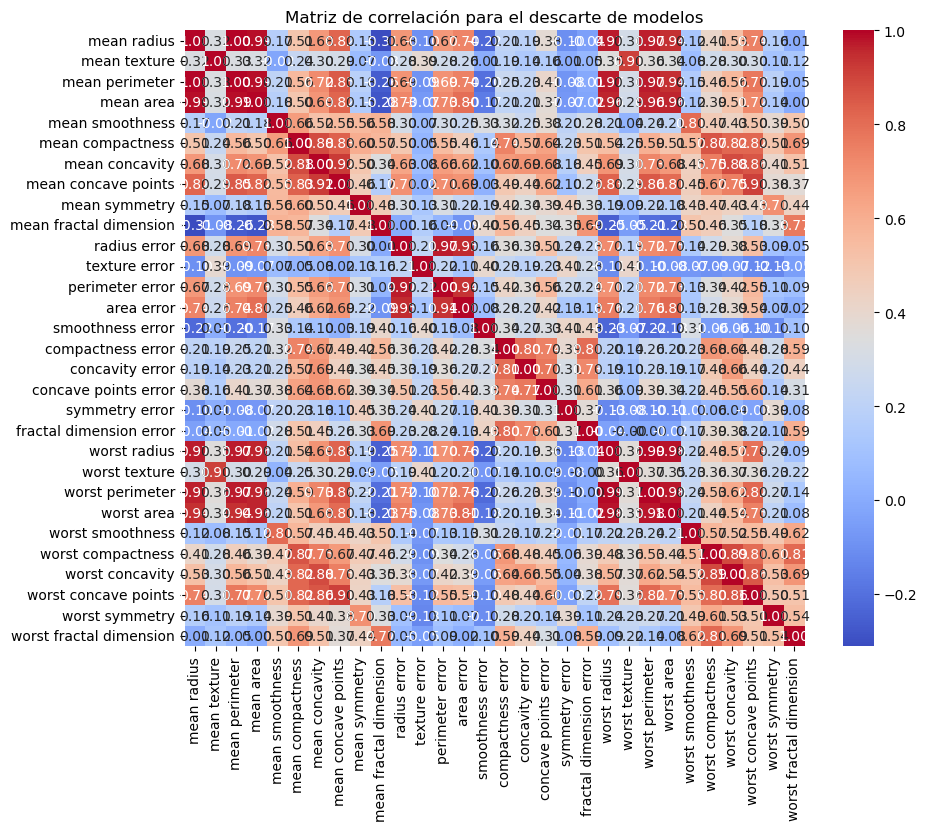

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer

SEED = 42
np.random.seed(SEED)

datos_cancer = load_breast_cancer()

x = datos_cancer.data
y = datos_cancer.target

x_df = pd.DataFrame(x, columns=datos_cancer.feature_names)


plt.figure(figsize=(10,8))
sns.heatmap(x_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación para el descarte de modelos")
plt.show()

# Revisar si hay datos nulos
print(x_df.isnull().sum())

In [2]:
# No hay datos nulos, entonces:
# División de los datos
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=SEED
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [3]:
# Función para evaluar cada modelo.
def evaluar_modelo(modelo, x_tr, x_ts, y_ts):
    modelo.fit(x_tr, y_train)
    pred = modelo.predict(x_ts)

    return accuracy_score(y_ts, pred)

In [4]:
resultados = {}

nb_model = GaussianNB()
resultados['Naive Bayes'] = evaluar_modelo(nb_model, x_train, x_test, y_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
resultados['KNN'] = evaluar_modelo(knn_model, x_train_scaled, x_test_scaled, y_test)

logisReg_model = LogisticRegression(solver='liblinear', random_state=SEED)
resultados['Regresión logística'] = evaluar_modelo(logisReg_model, x_train_scaled, x_test_scaled, y_test)

tree_model = DecisionTreeClassifier(random_state=SEED)
resultados['Árbol de decisión'] = evaluar_modelo(tree_model, x_train, x_test, y_test)

df_resultados = pd.DataFrame(list(resultados.items()), columns=['Modelo', 'Precisión'])
df_resultados = df_resultados.sort_values(by='Precisión', ascending=False)

print(df_resultados.set_index('Modelo'))

                     Precisión
Modelo                        
Regresión logística   0.982456
KNN                   0.959064
Naive Bayes           0.941520
Árbol de decisión     0.941520


In [5]:
# Como el modelo de regresión logística dio una precisión
# más alta, vamos a usar ese modelo para este ejercicio.

logisReg_model.fit(x_train_scaled, y_train)
print("Modelo entrenado exitosamente")

y_pred = logisReg_model.predict(x_test_scaled)
y_proba = logisReg_model.predict_proba(x_test_scaled)[:,1]

cm = confusion_matrix(y_test, y_pred)
print(f"\n{cm}")

print(classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno']))

auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC = {auc_score:.4f}")

Modelo entrenado exitosamente

[[ 62   1]
 [  2 106]]
              precision    recall  f1-score   support

     Maligno       0.97      0.98      0.98        63
     Benigno       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

AUC = 0.9979


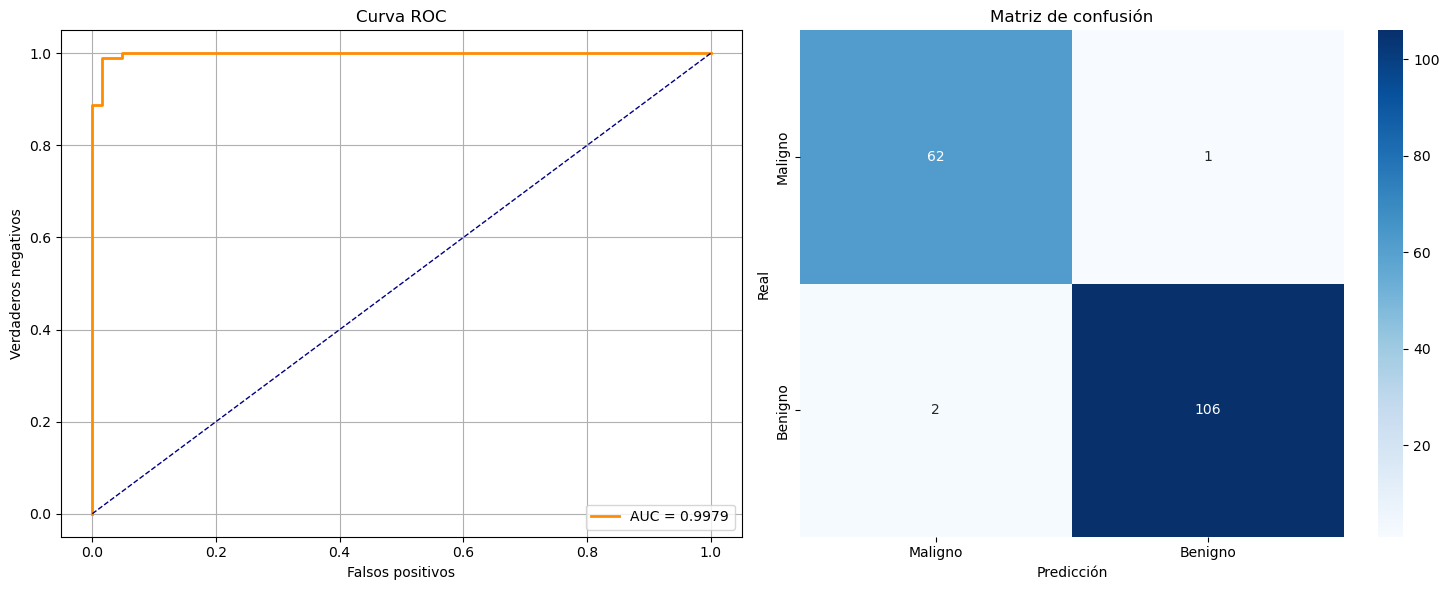

In [6]:
# Visualización de los datos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.4f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[0].set_xlabel('Falsos positivos')
axes[0].set_ylabel('Verdaderos negativos')
axes[0].set_title('Curva ROC')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Maligno', 'Benigno'], yticklabels=['Maligno', 'Benigno'])
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')
axes[1].set_title('Matriz de confusión')

plt.tight_layout()
plt.show()